In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark Credit Risk Modelling").config("spark.some.config.option", "some-value").getOrCreate()

In [3]:
credit_df = spark.read.csv("credit_risk_dataset.csv", header=True, inferSchema=True)
credit_df.printSchema()

root
 |-- person_age: integer (nullable = true)
 |-- person_income: integer (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- person_emp_length: double (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_grade: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- loan_int_rate: double (nullable = true)
 |-- loan_status: integer (nullable = true)
 |-- loan_percent_income: double (nullable = true)
 |-- cb_person_default_on_file: string (nullable = true)
 |-- cb_person_cred_hist_length: integer (nullable = true)



In [4]:
credit_df.show(10)

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        22|        59000|                 RENT|            123.0|   PERSONAL|         D|    35000|        16.02|          1|               0.59|                        Y|                         3|
|        21|         9600|                  OWN|              5.0|  EDUCATION|         B|     1000|        11.14|          0|                0.1|                        N|                         2|
|    

In [5]:
credit_pd_df = credit_df.toPandas()

<AxesSubplot:xlabel='loan_status', ylabel='count'>

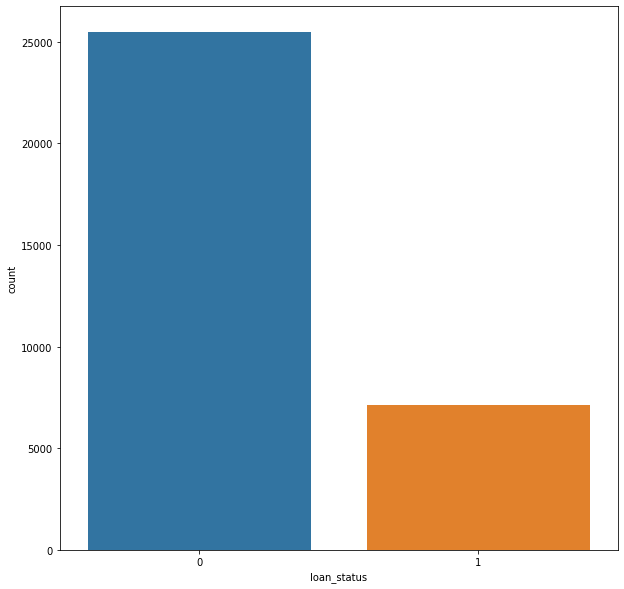

In [6]:
# get the number of defaulters in loan
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(x=credit_pd_df['loan_status'], data=credit_pd_df)

<AxesSubplot:xlabel='person_age', ylabel='Count'>

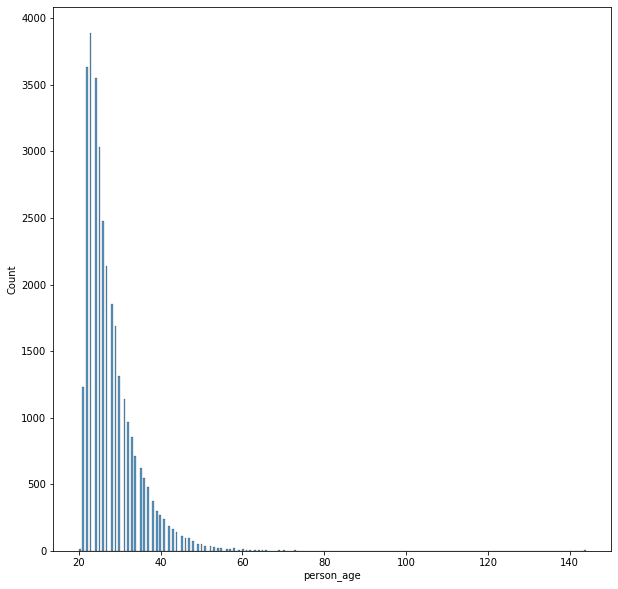

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data=credit_pd_df, x=credit_pd_df['person_age'], ax=ax)

<AxesSubplot:xlabel='person_home_ownership', ylabel='Count'>

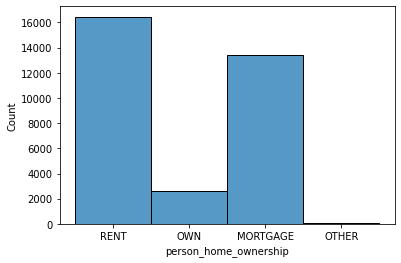

In [8]:
# what type of house do the people have
sns.histplot(data=credit_pd_df, x=credit_pd_df['person_home_ownership'])

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

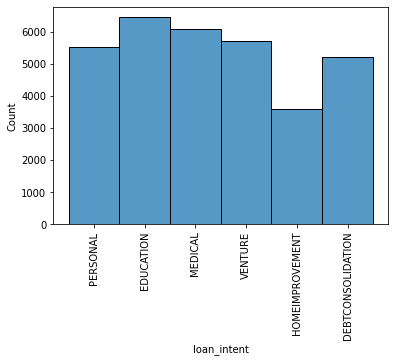

In [9]:
# Purpose of the loan
sns.histplot(data=credit_pd_df, x=credit_pd_df['loan_intent'])
plt.xticks(rotation=90)

In [10]:
# For better visualization let's use ploty
!pip install plotly

In [11]:
import plotly.express as pl

In [12]:
pl.histogram(data_frame=credit_pd_df, x=credit_pd_df['person_age'])

In [13]:
pl.histogram(data_frame=credit_pd_df, x=credit_pd_df['person_home_ownership'])

In [14]:
pl.histogram(data_frame=credit_pd_df, x=credit_pd_df['loan_intent'])

In [15]:
pl.histogram(data_frame=credit_pd_df, x=credit_pd_df['cb_person_cred_hist_length'])

In [16]:
# Handling missing in PySpark
def count_null(spark_df):
    null_count = []
    for col in spark_df.dtypes:
        cname = col[0]
        ctype = col[1]

        # check the count of null values in the column
        nulls = spark_df.where( spark_df[cname].isNull()).count()
        if nulls > 0:
            res = tuple([cname, nulls])
            null_count.append(res)
    return null_count

In [17]:
null_count = count_null(spark_df=credit_df)
null_count

[('person_emp_length', 895), ('loan_int_rate', 3116)]

In [18]:
# Now we will fill the missing values
# We will separate categorical missing features and numerical missing features

from pyspark.sql.functions import rank, sum, col, mean, round

def categorical_features(spark_df, cols):
    df = spark_df.na.drop()
    for col in cols:
        mode = df.groupBy().count().sort(col("count").desc()).collect()[0][0]
        print(col, mode)
        spark_df = spark_df.na.fill({col: mode})
    return spark_df


def numerical_features(spark_df, cols):
    df = spark_df.na.drop()
    for col in cols:
        meanvalue = spark_df.select(round(mean(col))).collect()[0][0] 
        print(col, meanvalue) 
        spark_df = spark_df.na.fill({col: meanvalue})
    return spark_df

list_cols_miss=[x[0] for x in null_count]
df_miss= credit_df.select(*list_cols_miss)

# categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("cateogrical columns_miss:", catcolums_miss)

# numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numerical columns_miss:", numcolumns_miss)

credit_df = categorical_features(credit_df, catcolums_miss)
credit_df = numerical_features(credit_df, numcolumns_miss)

cateogrical columns_miss: []
numerical columns_miss: ['person_emp_length', 'loan_int_rate']
person_emp_length 5.0
loan_int_rate 11.0


In [19]:
for column in credit_df.dtypes:
    cname = column[0]
    ctype = column[1]
    nulls = credit_df.where(credit_df[cname].isNull()).count()

    print(cname, ctype, nulls)

person_age int 0
person_income int 0
person_home_ownership string 0
person_emp_length double 0
loan_intent string 0
loan_grade string 0
loan_amnt int 0
loan_int_rate double 0
loan_status int 0
loan_percent_income double 0
cb_person_default_on_file string 0
cb_person_cred_hist_length int 0


In [20]:
# As our data is imbalace, we have to balance the dataset
# Either we can use SMOTE which will upsample the data and create new data points
# Or downsample the data which will result in loss of data

# Or we can weight the data and give higher weightage to minority classed and low weight to majority classes
# Let's go with weighting the classes

# adding the new column weights and fill it with ratios
from pyspark.sql.functions import when
ratio = 0.65
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))
credit_df = credit_df.withColumn('weights', weight_balance(col('loan_status')))
credit_df.show(10)

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|weights|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-------+
|        22|        59000|                 RENT|            123.0|   PERSONAL|         D|    35000|        16.02|          1|               0.59|                        Y|                         3|   0.65|
|        21|         9600|                  OWN|              5.0|  EDUCATION|         B|     1000|        11.14|          0|                0.1|                        N| 

In [21]:
# Now we have handled all the missing values
# Now it is time to do some other feature engineering

# First we will perform one-hot encoding on categorical features
categorical_cols = [item[0] for item in credit_df.dtypes if item[1].startswith('string')]
numerical_cols = [item[0] for item in credit_df.dtypes if item[1].startswith('int') | item[1].startswith('double')]

print(f"Categorical Columns : {categorical_cols}", f"\nNumerical Columns : {numerical_cols}")

Categorical Columns : ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'] 
Numerical Columns : ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length', 'weights']


In [22]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
categorical_stages = []
for cat_col in categorical_cols:
    stringIndex = StringIndexer(inputCol=cat_col, outputCol=f'{cat_col}_Index')
    encoder = OneHotEncoder(inputCol=stringIndex.getOutputCol(), outputCol=f'{cat_col}_Encode', dropLast=False)
    categorical_stages += [stringIndex, encoder]

In [23]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=categorical_stages)
pipelineModel = pipeline.fit(credit_df)
credit_df_transformed = pipelineModel.transform(credit_df)

credit_df_transformed.show(10)

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-------+---------------------------+----------------------------+-----------------+------------------+----------------+-----------------+-------------------------------+--------------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|weights|person_home_ownership_Index|person_home_ownership_Encode|loan_intent_Index|loan_intent_Encode|loan_grade_Index|loan_grade_Encode|cb_person_default_on_file_Index|cb_person_default_on_file_Encode|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+

In [24]:
numerical_cols = [item[0] for item in credit_df.dtypes if item[1].startswith('int') | item[1].startswith('double')]

print(numerical_cols)

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length', 'weights']


In [25]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

numerical_stages = []
for num_col in numerical_cols:
    if num_col != 'loan_status':
        assembler = VectorAssembler(inputCols=[num_col], outputCol=f'{num_col}_Vector')
        scale = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=f'{num_col}_Scale')
        numerical_stages += [assembler, scale]

In [26]:
from pyspark.ml import Pipeline
cols = credit_df.columns
pipeline = Pipeline(stages=numerical_stages)
pipelineModel = pipeline.fit(credit_df_transformed)
credit_df_transformed_new = pipelineModel.transform(credit_df_transformed)

credit_df_transformed_new.show(10)

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-------+---------------------------+----------------------------+-----------------+------------------+----------------+-----------------+-------------------------------+--------------------------------+-----------------+--------------------+--------------------+--------------------+------------------------+-----------------------+----------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+---------------------------------+--------------------------------+--------------+--------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|weights|person_home_ownership_Index

In [27]:
# Let's create a copy of the dataframe to keep it safe and work on the copy
credit_df_transformed_copy = credit_df_transformed_new.alias('credit_df_transformed_copy')
id(credit_df_transformed_copy) == id(credit_df_transformed_new)

False

In [28]:
credit_df_transformed_copy.columns

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length',
 'weights',
 'person_home_ownership_Index',
 'person_home_ownership_Encode',
 'loan_intent_Index',
 'loan_intent_Encode',
 'loan_grade_Index',
 'loan_grade_Encode',
 'cb_person_default_on_file_Index',
 'cb_person_default_on_file_Encode',
 'person_age_Vector',
 'person_age_Scale',
 'person_income_Vector',
 'person_income_Scale',
 'person_emp_length_Vector',
 'person_emp_length_Scale',
 'loan_amnt_Vector',
 'loan_amnt_Scale',
 'loan_int_rate_Vector',
 'loan_int_rate_Scale',
 'loan_percent_income_Vector',
 'loan_percent_income_Scale',
 'cb_person_cred_hist_length_Vector',
 'cb_person_cred_hist_length_Scale',
 'weights_Vector',
 'weights_Scale']

In [30]:
feature_columns = []
for col in credit_df_transformed_copy.dtypes:
    cname = col[0]
    if "Scale" in cname or "Encode" in cname:
        feature_columns.append(cname)

print(feature_columns)

['person_home_ownership_Encode', 'loan_intent_Encode', 'loan_grade_Encode', 'cb_person_default_on_file_Encode', 'person_age_Scale', 'person_income_Scale', 'person_emp_length_Scale', 'loan_amnt_Scale', 'loan_int_rate_Scale', 'loan_percent_income_Scale', 'cb_person_cred_hist_length_Scale', 'weights_Scale']


In [31]:
feature_columns.append('loan_status')
df = credit_df_transformed_copy.select([feature for feature in feature_columns])
df.show(10)

+----------------------------+------------------+-----------------+--------------------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+-------------------------+--------------------------------+--------------------+-----------+
|person_home_ownership_Encode|loan_intent_Encode|loan_grade_Encode|cb_person_default_on_file_Encode|    person_age_Scale| person_income_Scale|person_emp_length_Scale|     loan_amnt_Scale| loan_int_rate_Scale|loan_percent_income_Scale|cb_person_cred_hist_length_Scale|       weights_Scale|loan_status|
+----------------------------+------------------+-----------------+--------------------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+-------------------------+--------------------------------+--------------------+-----------+
|               (4,[0],[1.0])|     (6,[3],[1.0])|    (7,[3],[1.0])|                   (2,[1],[1.0

In [32]:
from pyspark.ml.classification import LogisticRegression

train, test = df.randomSplit([0.80, 0.20], seed = 42)

features = VectorAssembler(inputCols=feature_columns, outputCol="features")
model_lr = LogisticRegression(featuresCol='features', labelCol='loan_status')
pipeline_lr = Pipeline(stages=[features, model_lr])

In [33]:
print(train.count())
print(test.count())

26092
6489


In [34]:
train.columns

['person_home_ownership_Encode',
 'loan_intent_Encode',
 'loan_grade_Encode',
 'cb_person_default_on_file_Encode',
 'person_age_Scale',
 'person_income_Scale',
 'person_emp_length_Scale',
 'loan_amnt_Scale',
 'loan_int_rate_Scale',
 'loan_percent_income_Scale',
 'cb_person_cred_hist_length_Scale',
 'weights_Scale',
 'loan_status']

In [35]:
test.columns

['person_home_ownership_Encode',
 'loan_intent_Encode',
 'loan_grade_Encode',
 'cb_person_default_on_file_Encode',
 'person_age_Scale',
 'person_income_Scale',
 'person_emp_length_Scale',
 'loan_amnt_Scale',
 'loan_int_rate_Scale',
 'loan_percent_income_Scale',
 'cb_person_cred_hist_length_Scale',
 'weights_Scale',
 'loan_status']

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="loan_status")

model_fit = pipeline_lr.fit(train)
model_fit

PipelineModel_88818724a778

In [37]:
predict = model_fit.transform(test)
predict

DataFrame[person_home_ownership_Encode: vector, loan_intent_Encode: vector, loan_grade_Encode: vector, cb_person_default_on_file_Encode: vector, person_age_Scale: vector, person_income_Scale: vector, person_emp_length_Scale: vector, loan_amnt_Scale: vector, loan_int_rate_Scale: vector, loan_percent_income_Scale: vector, cb_person_cred_hist_length_Scale: vector, weights_Scale: vector, loan_status: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [38]:
evaluator.evaluate(predict, {evaluator.metricName: 'areaUnderPR'})

1.0

In [43]:
from pyspark.ml.classification import DecisionTreeClassifier

train, test = df.randomSplit([0.70, 0.30], seed = 42)

features = VectorAssembler(inputCols=feature_columns, outputCol="features")
model_dt = DecisionTreeClassifier(featuresCol="features", labelCol="loan_status")
pipeline_lr = Pipeline(stages=[features, model_dt])

In [44]:
model_fit = pipeline_lr.fit(train)
predict = model_fit.transform(test)

In [45]:
evaluator.evaluate(predict, {evaluator.metricName: 'areaUnderPR'})

1.0